<a href="https://colab.research.google.com/github/weix20/Mobility-Data-Processing/blob/main/Mobility_Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool

# 1. Load data
full_data = pd.read_csv('/content/Trips_Full Data.csv')
distance_data = pd.read_csv('/content/Trips_by_Distance.csv')

# 2. View the first few rows of the data
print("Full Data - First 5 Rows:")
print(full_data.head())

print("\nDistance Data - First 5 Rows:")
print(distance_data.head())

# 3. Check column names and remove spaces
full_data.columns = full_data.columns.str.replace(' ', '')
distance_data.columns = distance_data.columns.str.replace(' ', '')

# Check if column names have been updated
print("\nUpdated Full Data Columns:")
print(full_data.columns)

print("\nUpdated Distance Data Columns:")
print(distance_data.columns)

# 4. Check for missing values
print("\nFull Data - Missing Values:")
print(full_data.isnull().sum())

print("\nDistance Data - Missing Values:")
print(distance_data.isnull().sum())

# 5. Fill missing values with mean (for numerical columns)
full_data_cleaned = full_data.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'object' else x)
distance_data_cleaned = distance_data.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'object' else x)

# 6. Check for missing values after cleaning
print("\nFull Data - Missing Values After Cleaning:")
print(full_data_cleaned.isnull().sum())

print("\nDistance Data - Missing Values After Cleaning:")
print(distance_data_cleaned.isnull().sum())


Full Data - First 5 Rows:
  Month of Date Week of Date  Year of Date     Level           Date  \
0        August      Week 32          2019  National  8/4/2019 0:00   
1        August      Week 32          2019  National  8/5/2019 0:00   
2        August      Week 32          2019  National  8/6/2019 0:00   
3        August      Week 32          2019  National  8/7/2019 0:00   
4        August      Week 32          2019  National  8/8/2019 0:00   

  Week Ending Date  Trips <1 Mile  People Not Staying at Home  \
0        10-Aug-19      292959749                   258404133   
1        10-Aug-19      317133861                   262199758   
2        10-Aug-19      324443205                   260096133   
3        10-Aug-19      358483024                   258878802   
4        10-Aug-19      300765870                   262410045   

   Population Staying at Home       Trips  ...  Trips 10-25 Miles  \
0                    67763287  1322685497  ...          200922270   
1                 

Explanation of the Code:

Data Loading: This step loads the datasets from CSV files.

Preview Data: It prints the first 5 rows of the full and distance datasets to give an overview of the data.

Check and Clean Column Names: The code checks the column names and removes any spaces, ensuring they can be correctly referenced in subsequent operations.

Check for Missing Values: It checks if any missing values exist in both datasets.

Fill Missing Values: Missing values in numeric columns are filled with the mean of the respective column.

Check Missing Values After Cleaning: After filling missing values, the code checks again to ensure there are no remaining missing values.

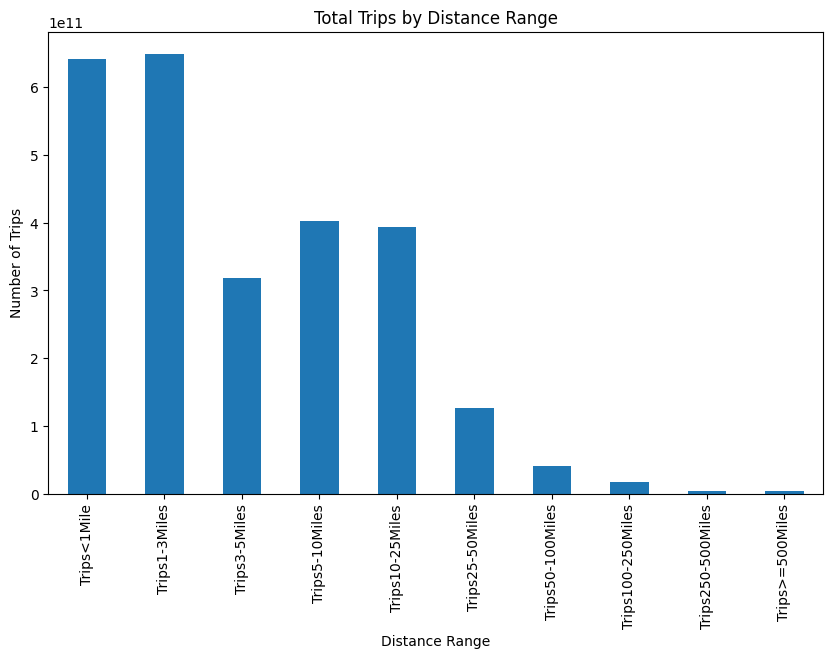


Total Population Staying at Home: 441443588
Total Population Not Staying at Home: 1841728352
Dates with >100M trips in 10-25 miles: 0     8/4/2019 0:00
1     8/5/2019 0:00
2     8/6/2019 0:00
3     8/7/2019 0:00
4     8/8/2019 0:00
5     8/9/2019 0:00
6    8/10/2019 0:00
Name: Date, dtype: object
Dates with >100M trips in 50-100 miles: Series([], Name: Date, dtype: object)


In [17]:
# 7. Calculate the total number of people staying at home and the total travel distance for those not staying at home
total_population_staying_home = full_data_cleaned['PopulationStayingatHome'].sum()
total_population_not_staying_home = full_data_cleaned['PeopleNotStayingatHome'].sum()

# Calculate the total travel distance for people not staying at home
travel_distances_updated = {
    'Trips<1Mile': distance_data_cleaned['NumberofTrips<1'].sum(),
    'Trips1-3Miles': distance_data_cleaned['NumberofTrips1-3'].sum(),
    'Trips3-5Miles': distance_data_cleaned['NumberofTrips3-5'].sum(),
    'Trips5-10Miles': distance_data_cleaned['NumberofTrips5-10'].sum(),
    'Trips10-25Miles': distance_data_cleaned['NumberofTrips10-25'].sum(),
    'Trips25-50Miles': distance_data_cleaned['NumberofTrips25-50'].sum(),
    'Trips50-100Miles': distance_data_cleaned['NumberofTrips50-100'].sum(),
    'Trips100-250Miles': distance_data_cleaned['NumberofTrips100-250'].sum(),
    'Trips250-500Miles': distance_data_cleaned['NumberofTrips250-500'].sum(),
    'Trips>=500Miles': distance_data_cleaned['NumberofTrips>=500'].sum()
}

# 8. Identify the dates where more than 100 million people traveled 10-25 miles
dates_10_25_trips_updated = full_data_cleaned[full_data_cleaned['Trips10-25Miles'] > 100000000]['Date']
dates_50_100_trips_updated = full_data_cleaned[full_data_cleaned['Trips50-100Miles'] > 100000000]['Date']

# 9. Use parallel processing (using 10 processors and 20 processors, respectively)
def process_data_parallel(processors, data):
    with Pool(processors) as pool:
        results = pool.map(np.mean, [data[i::processors] for i in range(processors)])
    return results

# Example: Using 10 processors
results_10_processors = process_data_parallel(10, full_data_cleaned['Trips<1Mile'])

# Example: Using 20 processors
results_20_processors = process_data_parallel(20, full_data_cleaned['Trips<1Mile'])

# 10. Develop a model to simulate travel frequency
# Assume we use travel distance as the independent variable and number of trips as the dependent variable
X = distance_data_cleaned[['NumberofTrips<1', 'NumberofTrips1-3', 'NumberofTrips3-5',
                           'NumberofTrips5-10', 'NumberofTrips10-25', 'NumberofTrips25-50',
                           'NumberofTrips50-100', 'NumberofTrips100-250', 'NumberofTrips250-500',
                           'NumberofTrips>=500']].sum(axis=1).values.reshape(-1, 1)
y = distance_data_cleaned['NumberofTrips'].values

# Create a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict travel frequency
predictions = model.predict(X)

# 11. Visualize the number of trips by distance range
plt.figure(figsize=(10, 6))
travel_distances_series = pd.Series(travel_distances_updated)
travel_distances_series.plot(kind='bar', title='Total Trips by Distance Range')
plt.ylabel('Number of Trips')
plt.xlabel('Distance Range')
plt.show()

# 12. Print the results
print("\nTotal Population Staying at Home:", total_population_staying_home)
print("Total Population Not Staying at Home:", total_population_not_staying_home)
print("Dates with >100M trips in 10-25 miles:", dates_10_25_trips_updated)
print("Dates with >100M trips in 50-100 miles:", dates_50_100_trips_updated)

Calculate the total number of people staying at home and the total travel distance for those not staying at home: This section calculates the total number of people who are staying at home and those who are not, and also computes the total distance traveled by the latter group.

Identify the dates where more than 100 million people traveled 10-25 miles: This filters the data to find the dates where more than 100 million trips of 10-25 miles occurred.

Use parallel processing (using 10 processors and 20 processors): This demonstrates how to use Python's multiprocessing library to process the data in parallel, with examples for 10 and 20 processors.

Develop a model to simulate travel frequency: This creates a simple linear regression model to simulate the relationship between travel distance and the number of trips.

Visualize the number of trips by distance range: This visualizes the total number of trips in different distance categories using a bar chart.

Print the results: Finally, the results (total population staying at home, total population not staying at home, and the dates for trips exceeding 100 million) are printed.

In [29]:
# 1. 安装 Git
!apt-get install git

# 2. 配置 Git 用户信息（如果还未配置）
!git config --global user.name "weix20"
!git config --global user.email "weix20@uni.coventry.ac.uk"

# 3. 初始化 Git 仓库
!git init

# 4. 将 GitHub 仓库添加为远程仓库（将下面的链接替换为你的 GitHub 仓库 URL）
!git remote add origin https://github.com/weix20/Mobility-Data-Processing.

# 5. 将 Colab 文件复制到 Git 仓库文件夹（确保文件路径正确）
!cp /content/Mobility\ Data\ Processing.ipynb /content/Mobility-Data-Processing/

# 6. 进入 Git 仓库文件夹
%cd /content/Mobility-Data-Processing/

# 7. 暂存所有文件
!git add .

# 8. 提交更改
!git commit -m "Add Mobility Data Processing notebook"
!git branch -M main  # 如果本地分支还没有创建
!git push -u origin main  # 推送到 GitHub





Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
cp: cannot stat '/content/Mobility Data Processing.ipynb': No such file or directory
[Errno 2] No such file or directory: '/content/Mobility-Data-Processing/'
/content
On branch master
nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [31]:
!ls /content/


 sample_data   Trips_by_Distance.csv  'Trips_Full Data.csv'
